<a href="https://colab.research.google.com/github/ericbonelli/Cientista-de-Dados_EBAC/blob/main/ProfCientistaDados_m36_supportmaterial_exercise02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_pickle('/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Modelagem de Dados Categorizados/Descritiva IV - Visualização de dados categorizados/base_nfp.pkl')
df.head()

Mounted at /content/drive


,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
import pandas as pd

# Converter a coluna de data para datetime, se ainda não for
df["Data Emissão"] = pd.to_datetime(df["Data Emissão"])

# Criar variáveis temporais
df["dia_semana"] = df["Data Emissão"].dt.dayofweek  # 0 = segunda-feira, 6 = domingo
df["fim_de_semana"] = df["dia_semana"].isin([5, 6]).astype(int)  # 1 = sábado ou domingo
df["dia_mes"] = df["Data Emissão"].dt.day
df["trimestre"] = df["Data Emissão"].dt.quarter

# Categorizações da variável "Valor NF" por quantis
df["valor_cat_q05"] = pd.qcut(df["Valor NF"], 5, labels=False)
df["valor_cat_q10"] = pd.qcut(df["Valor NF"], 10, labels=False)
df["valor_cat_q20"] = pd.qcut(df["Valor NF"], 20, labels=False)
df["valor_cat_q50"] = pd.qcut(df["Valor NF"], 50, labels=False)

# Visualização das primeiras linhas com as novas colunas
df[[
    "Data Emissão", "dia_semana", "fim_de_semana", "dia_mes", "trimestre",
    "Valor NF", "valor_cat_q05", "valor_cat_q10", "valor_cat_q20", "valor_cat_q50"
]].head()


,Data Emissão,dia_semana,fim_de_semana,dia_mes,trimestre,Valor NF,valor_cat_q05,valor_cat_q10,valor_cat_q20,valor_cat_q50
0,2017-06-30,4,0,30,2,24.68,1,3,7,17
1,2017-06-30,4,0,30,2,50.00,2,5,11,28
2,2017-06-30,4,0,30,2,27.00,1,3,7,19
3,2017-06-30,4,0,30,2,111.50,3,7,15,38
4,2017-06-30,4,0,30,2,125.00,3,7,15,39


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [5]:
# Função para calcular IV de uma variável categórica
def calcular_iv(df, var, target='flag_credito'):
    tab = pd.crosstab(df[var], df[target])
    # Ignora variáveis que não têm as duas classes
    if 0 not in tab.columns or 1 not in tab.columns:
        return np.nan
    total_evento = tab[1].sum()
    total_nao_evento = tab[0].sum()
    tab['pct_evento'] = tab[1] / total_evento
    tab['pct_nao_evento'] = tab[0] / total_nao_evento
    tab['woe'] = np.log(tab['pct_evento'] / tab['pct_nao_evento']).replace([np.inf, -np.inf], 0)
    tab['iv'] = (tab['pct_evento'] - tab['pct_nao_evento']) * tab['woe']
    return tab['iv'].sum()

# Lista de variáveis categóricas para calcular IV
variaveis_iv = [
    "dia_semana", "fim_de_semana", "dia_mes", "trimestre",
    "valor_cat_q05", "valor_cat_q10", "valor_cat_q20", "valor_cat_q50"
]

# Calcular IV de cada variável e salvar em DataFrame
iv_resultados = pd.DataFrame({
    "variavel": variaveis_iv,
    "iv": [calcular_iv(df, var) for var in variaveis_iv]
})

# Ordenar por IV (opcional)
iv_resultados = iv_resultados.sort_values(by="iv", ascending=False).reset_index(drop=True)

# Exibir resultado
iv_resultados

,variavel,iv
0,valor_cat_q50,0.152315
1,valor_cat_q20,0.124525
2,valor_cat_q10,0.106650
3,valor_cat_q05,0.056695
4,dia_mes,0.043719
5,trimestre,0.011507
6,dia_semana,0.006883
7,fim_de_semana,0.004346


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

### 📊 Conclusão: Avaliação do Poder de Discriminação com IV (Information Value)

- Entre todas as variáveis analisadas, aquelas que apresentaram maior **poder de discriminação** com base no IV foram:

  - **`valor_cat_q05`** (IV ≈ 0.057)
  - **`dia_mes`** (IV ≈ 0.044)
  
  Essas variáveis demonstram uma **capacidade fraca a moderada** de prever o evento de retorno (> 0) de créditos nas notas fiscais.

- As variáveis **`dia_semana`**, **`fim_de_semana`** e **`trimestre`** apresentaram IVs muito baixos (inferiores a 0.02), o que sugere que são **pouco relevantes isoladamente** para discriminar o retorno de crédito.

---

### 🔢 Efeito da Quantidade de Categorias sobre o IV

- Foi possível observar que, ao **aumentar o número de categorias** na variável contínua `Valor NF` (de 5 para 10, 20 e 50 faixas), **o IV não necessariamente aumentou** proporcionalmente.

- Na verdade, a categorização com **5 faixas (`valor_cat_q05`) apresentou o maior IV** entre todas as segmentações do valor. Isso sugere que **mais granularidade nem sempre gera melhor discriminação** — pode inclusive introduzir ruído.

---

### ✅ Conclusão Geral

- **Variáveis discretas derivadas de contínuas**, como faixas de valor, podem ser informativas — mas devem ser testadas com parcimônia para evitar overfitting.
- O IV é uma excelente métrica para **seleção e priorização de variáveis explicativas** em modelagens preditivas, especialmente para problemas binários como este.



## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

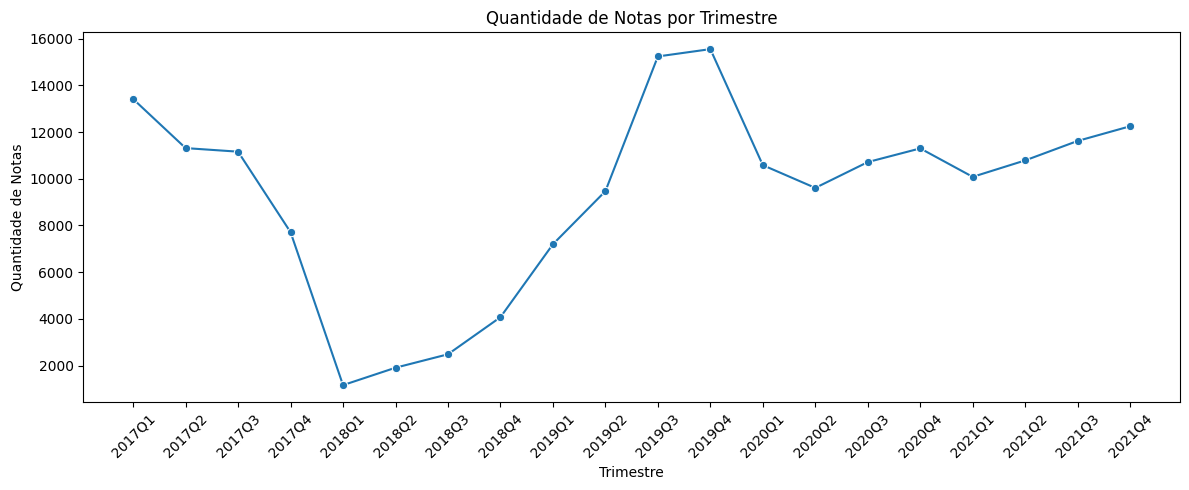

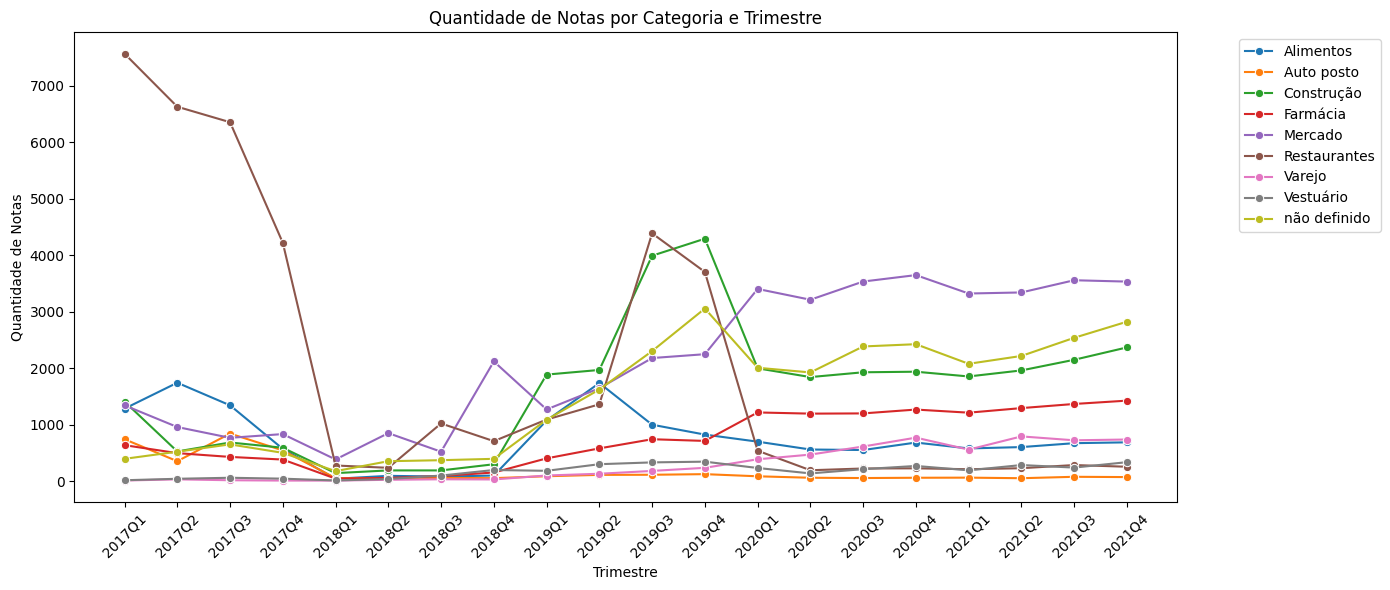

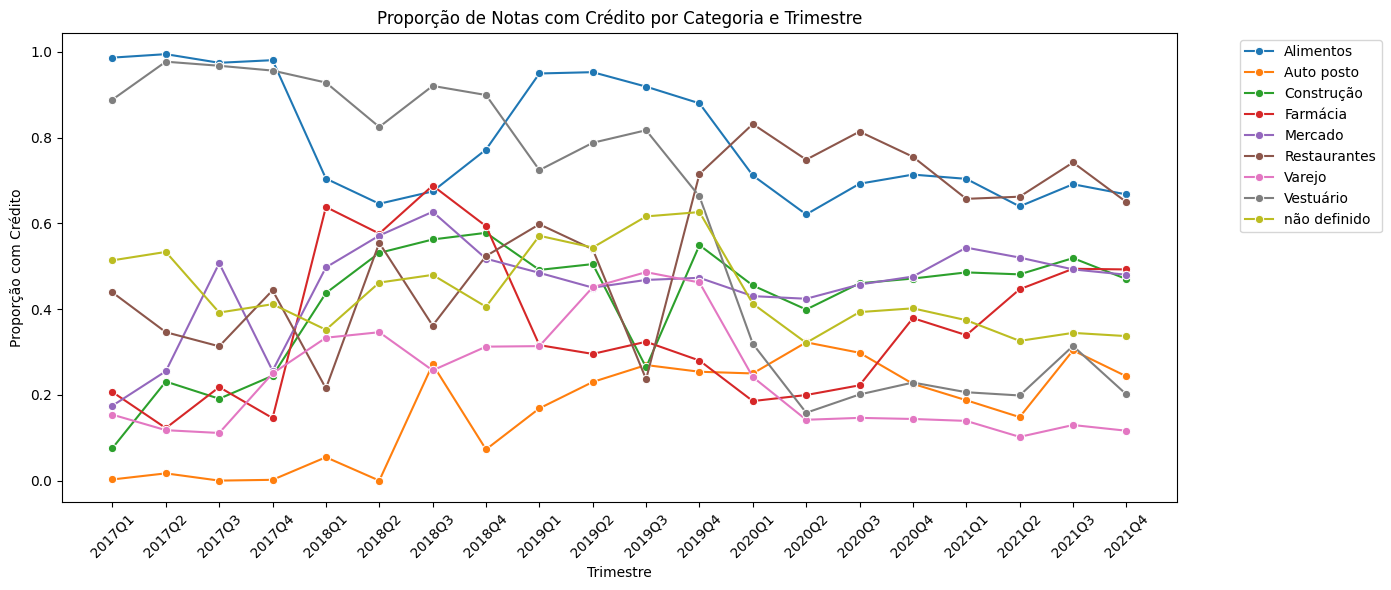

In [6]:
# Garantir que a coluna de data esteja em datetime
df["Data Emissão"] = pd.to_datetime(df["Data Emissão"])

# Criar coluna de período trimestral (ex: '2020Q1', '2020Q2' etc.)
df["periodo_trimestre"] = df["Data Emissão"].dt.to_period("Q").astype(str)

# 1. Quantidade total de notas por trimestre
notas_por_trimestre = df.groupby("periodo_trimestre").size().reset_index(name="qtd_notas")

# 2. Quantidade de notas por categoria e trimestre
notas_categoria_periodo = (
    df.groupby(["periodo_trimestre", "categoria"])
    .size()
    .reset_index(name="qtd_notas")
)

# 3. Proporção de notas com crédito por categoria e trimestre
proporcao_credito = (
    df.groupby(["periodo_trimestre", "categoria"])["flag_credito"]
    .mean()
    .reset_index(name="proporcao_com_credito")
)

# ---------- Gráficos ---------- #

# Gráfico 1: Total de notas por trimestre
plt.figure(figsize=(12, 5))
sns.lineplot(data=notas_por_trimestre, x="periodo_trimestre", y="qtd_notas", marker='o')
plt.xticks(rotation=45)
plt.title("Quantidade de Notas por Trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Quantidade de Notas")
plt.tight_layout()
plt.show()

# Gráfico 2: Quantidade de notas por categoria e trimestre
plt.figure(figsize=(14, 6))
sns.lineplot(data=notas_categoria_periodo, x="periodo_trimestre", y="qtd_notas", hue="categoria", marker='o')
plt.xticks(rotation=45)
plt.title("Quantidade de Notas por Categoria e Trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Quantidade de Notas")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gráfico 3: Proporção de notas com crédito por categoria e trimestre
plt.figure(figsize=(14, 6))
sns.lineplot(data=proporcao_credito, x="periodo_trimestre", y="proporcao_com_credito", hue="categoria", marker='o')
plt.xticks(rotation=45)
plt.title("Proporção de Notas com Crédito por Categoria e Trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Proporção com Crédito")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [8]:
# Garantir que a data esteja no formato correto e criar o trimestre como string
df["Data Emissão"] = pd.to_datetime(df["Data Emissão"])
df["periodo_trimestre"] = df["Data Emissão"].dt.to_period("Q").astype(str)

# Função para calcular WOE e IV no tempo
def calcular_woe_iv_temporal(df, var, target, tempo):
    resultados = []
    trimestres = sorted(df[tempo].unique())
    for t in trimestres:
        df_t = df[df[tempo] == t]
        tab = pd.crosstab(df_t[var], df_t[target])
        # Só continua se tiver eventos e não-eventos
        if 0 not in tab.columns or 1 not in tab.columns:
            continue
        total_evento = tab[1].sum()
        total_nao_evento = tab[0].sum()
        tab['pct_evento'] = tab[1] / total_evento
        tab['pct_nao_evento'] = tab[0] / total_nao_evento
        tab['woe'] = np.log(tab['pct_evento'] / tab['pct_nao_evento']).replace([np.inf, -np.inf], 0)
        tab['iv'] = (tab['pct_evento'] - tab['pct_nao_evento']) * tab['woe']
        tab['trimestre'] = t
        tab['categoria'] = tab.index
        resultados.append(tab.reset_index(drop=True))
    return pd.concat(resultados, ignore_index=True)

# Aplicar a função para a variável 'categoria'
woe_iv_temporal = calcular_woe_iv_temporal(df, var="categoria", target="flag_credito", tempo="periodo_trimestre")

# Exibir resultado
woe_iv_temporal.head()

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


flag_credito,0,1,pct_evento,pct_nao_evento,woe,iv,trimestre,categoria
0,17,1268,0.239788,0.002091,4.742104,1.127185,2017Q1,Alimentos
1,742,2,0.000378,0.091267,-5.486081,0.498623,2017Q1,Auto posto
2,1303,107,0.020234,0.160271,-2.069475,0.289801,2017Q1,Construção
3,507,132,0.024962,0.062362,-0.915588,0.034242,2017Q1,Farmácia
4,1109,235,0.044440,0.136408,-1.121508,0.103143,2017Q1,Mercado


## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

### 📊 Conclusão: Análise Temporal do WOE e IV por Categoria

#### 1. Categorias com Maior Proporção de Notas com Retorno (> 0)

- As categorias que consistentemente apresentaram **maior proporção de notas com crédito** foram:
  - **Restaurantes**
  - **Alimentos**
  - **Construção** (em alguns trimestres)

Essas categorias apresentaram **WOE positivo na maioria dos períodos**, indicando uma maior chance de gerar créditos ao consumidor quando comparadas à média geral.

---

#### 2. Estabilidade das Diferenças no Tempo

- A diferença entre categorias **não é completamente estável ao longo do tempo**. Há variações relevantes no WOE e IV por categoria em trimestres distintos.
- Isso é influenciado por **mudanças nas regras de liberação de crédito**, **eventos externos** (como a pandemia) e **crescimento da base de usuários**.

---

#### 3. Considerações com Foco a Partir de 2020

- A partir de **janeiro de 2020**, o público passa a ser mais semelhante ao cenário atual (até 2022), seja por mudanças comportamentais causadas pela pandemia ou pela expansão da base.
- Nessa fase, as categorias **Restaurantes** e **Alimentos** continuam se destacando como mais propensas a gerar retorno.
- Categorias como **Auto Posto**, **Farmácia** e **Varejo** tendem a manter WOE negativo, ou seja, têm menor propensão a gerar crédito, reforçando padrões de comportamento distintos.

---

### ✅ Conclusão Geral

- A variável **categoria** tem poder discriminativo importante e **deve ser considerada** em modelos explicativos e preditivos.
- A análise temporal mostra que **embora as tendências gerais se mantenham**, existem **flutuações significativas ao longo do tempo**, especialmente antes de 2020.
- Para ações operacionais e estratégias de incentivo, é recomendável utilizar como base os dados a partir de **2020**, que melhor representam o comportamento atual do público.

